In [ ]:
#reqs
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import pickle
from google.colab import drive

#mount google drive
drive.mount('/content/drive')

#load data and tokenizer
with open('/content/drive/MyDrive/reduced_data3.pkl', 'rb') as f:
    data = pickle.load(f)
with open('/content/drive/MyDrive/tokenizer3.pkl', 'rb') as f:
    tokenizer = pickle.load(f)




Mounted at /content/drive


In [ ]:
#Some helper funtions. 
#Average is used for measuring the loss change over time in order to know when to reduce the learning rate.
# get_lr_metric keeps track of the laerning rate, since I'm not using built in tools it's useful for testing
def Average(lst): 
    return sum(lst) / len(lst) 

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [ ]:
#Set batch size, necessary for stateful RNN
batch_size_per_author = 150
#This is the definition of all the shared layers. B/C of stateful RNN and the classifier/generator split, these will be reused in all the models
embedding = layers.Embedding(len(tokenizer.word_index) + 1, 750, input_length=100)
RNN1 = layers.GRU(2250, stateful=True)
dense1 = layers.Dense(1250)

#These are generator/classifier specific layers. Generator layer is shared by all diff generators. Classifier is not, but it's here for organizational consistency
generator_dense_final = layers.Dense(len(tokenizer.word_index) + 1, activation='softmax')
classifier_dense_final = layers.Dense(6, activation='softmax')


In [ ]:
#The model path. Different outputs for gen and class, but uses the same structure mostly
inputs = keras.Input(batch_input_shape=(6*batch_size_per_author,100))
x = embedding(inputs)
x = RNN1(x)
# x = RNN2(x)
# x = RNN3(x)
x = dense1(x)
generator_output = generator_dense_final(x)
classifier_output = classifier_dense_final(x)

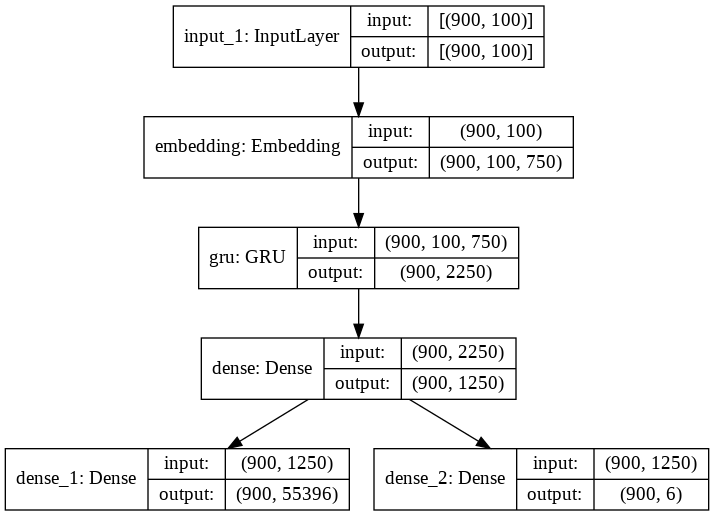

In [ ]:
#Define the model based inputs and outputs. Then plot it
model = keras.Model(
    inputs=[inputs],
    outputs=[generator_output, classifier_output],
)
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
#Custom class for handling data batches. Since I'm setting stateful to True, each position i in batch n has to be the next timestep in batch n+1
#Therefore, it chooses random starting points, the amount determined by the batch size, and then moves foward by one timestep in the data after the batch is retrieved
#It's like a gathering data from n random points in the data that move forward by one each time you get them
class Data:
  def __init__ (self, data, batch_size, vocab_length):
    self.data = data
    self.batch_size = batch_size
    self.lengths = [len(x) for x in data]
    self.counters = self.create_counters()
    self.vocab_length = vocab_length
  def next_batch(self):
    X = []
    y_class = []
    y_gen = []
    for i in range(len(self.data)):
      for ii in range(self.batch_size):
        X.append(data[i][self.counters[i][ii]][0])
        y_class.append(data[i][self.counters[i][ii]][1])
        y_gen.append(data[i][self.counters[i][ii]][2])
    self.update_counters()
    return np.asarray(X), keras.utils.to_categorical(y_gen, num_classes=self.vocab_length), np.asarray(y_class)
  def create_counters(self):
    counters = {}
    for i in (range(len(self.data))):
      counters[i] = random.sample(range(len(data[i])-1), self.batch_size)
    return counters
  def update_counters(self):
    for key  in self.counters:
      for i in range(len(self.counters[key])):
        self.counters[key][i] =  (self.counters[key][i] + 1) % self.lengths[key]


In [ ]:
#set some basic parameters, and define the Data obect
batches = 20000
current_lr = .0002

data_getter = Data(data, batch_size_per_author, len(tokenizer.word_index) + 1)

#set up optimizer and compile
optimizer = tf.keras.optimizers.Adam(learning_rate=current_lr)
lr_metric = get_lr_metric(optimizer)
model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model3/model_v3_final?', compile=False)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy',lr_metric])



In [ ]:

for i in range(batches):

    #Save the model every 2k batches. Also save the iteration of collab failing (num — this is outdated and should be removed), the learning rate, and the loss list. 
    #These are in case something fails in colab
    if ((i % 2001) == 0 and (i != 0)):
      num += 1 
      model.save('/content/drive/MyDrive/saved_model3/model_v3.1_' + str(num) + str(i))
      pickle.dump(num, open('/content/drive/MyDrive/num.pkl', 'wb+'))
      pickle.dump(current_lr, open('/content/drive/MyDrive/lr.pkl', "wb+"))
      pickle.dump(loss_list, open('/content/drive/MyDrive/loss.pkl', "wb+"))
  
    if (i%50 == 0):
      print("Batch Num: " + str(i))

    #Get Data
    totalX, total_gen_y, total_class_y = data_getter.next_batch()

    #Train Model
    total_loss, loss_g, loss_c, acc_g, lr_g, acc_c, lr_c = model.train_on_batch(totalX, [total_gen_y, total_class_y])
    loss_list.append([loss_g, loss_c])
    
    if (i%50 == 0):     
      print("loss_g: " + str(loss_g) + " accuracy_g:" + str(acc_g) + " lr_g:" + str(lr_g))
      print("loss_c: " + str(loss_c) + " accuracy_c:" + str(acc_c) + " lr_c:" + str(lr_c))

    #Every 1k batches, check if average has decreased. If it hasn't decreased signifigantly, lower learning rate
    if (i%1000 == 0 and i != 0):
      g_loss = [x[0] for x in loss_list]
      c_loss = [x[1] for x in loss_list]
      if Average(g_loss[-999:-500]) - Average(g_loss[-500:-1]) <= 0.1:
        print(Average(g_loss[-999:-500]))
        print(Average(g_loss[-500:-1]))
        current_lr = current_lr * .9
      optimizer.lr.assign(current_lr)


Batch Num: 0
loss_g: 2.3580894470214844 accuracy_g:0.5433333516120911 lr_g:0.00019999999494757503
loss_c: 2.458376548020169e-05 accuracy_c:1.0 lr_c:0.00019999999494757503
Batch Num: 50
loss_g: 2.019134283065796 accuracy_g:0.6077777743339539 lr_g:0.00019999999494757503
loss_c: 1.2660094398597721e-05 accuracy_c:1.0 lr_c:0.00019999999494757503
Batch Num: 100
loss_g: 1.950872540473938 accuracy_g:0.6088888645172119 lr_g:0.00019999999494757503
loss_c: 0.0001987215509871021 accuracy_c:1.0 lr_c:0.00019999999494757503
Batch Num: 150
loss_g: 1.990331768989563 accuracy_g:0.5844444632530212 lr_g:0.00019999999494757503
loss_c: 7.36782603780739e-05 accuracy_c:1.0 lr_c:0.00019999999494757503
Batch Num: 200
loss_g: 1.9363983869552612 accuracy_g:0.6088888645172119 lr_g:0.00019999999494757503
loss_c: 5.562034493777901e-05 accuracy_c:1.0 lr_c:0.00019999999494757503
Batch Num: 250
loss_g: 1.759264349937439 accuracy_g:0.6333333253860474 lr_g:0.00019999999494757503
loss_c: 2.4836497686919756e-05 accuracy_c:

INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model3/model_v3.1_12001/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model3/model_v3.1_12001/assets


Batch Num: 2050
loss_g: 1.6660717725753784 accuracy_g:0.647777795791626 lr_g:0.00018000000272877514
loss_c: 5.852690264873672e-06 accuracy_c:1.0 lr_c:0.00018000000272877514
Batch Num: 2100
loss_g: 1.5916495323181152 accuracy_g:0.6800000071525574 lr_g:0.00018000000272877514
loss_c: 9.624357517168391e-06 accuracy_c:1.0 lr_c:0.00018000000272877514
Batch Num: 2150
loss_g: 1.6244151592254639 accuracy_g:0.6833333373069763 lr_g:0.00018000000272877514
loss_c: 1.9344710381119512e-05 accuracy_c:1.0 lr_c:0.00018000000272877514
Batch Num: 2200
loss_g: 1.6812382936477661 accuracy_g:0.652222216129303 lr_g:0.00018000000272877514
loss_c: 4.678045115724672e-06 accuracy_c:1.0 lr_c:0.00018000000272877514
Batch Num: 2250
loss_g: 1.6092838048934937 accuracy_g:0.6688888669013977 lr_g:0.00018000000272877514
loss_c: 0.0018052932573482394 accuracy_c:0.9988889098167419 lr_c:0.00018000000272877514
Batch Num: 2300
loss_g: 1.6099885702133179 accuracy_g:0.6633333563804626 lr_g:0.00018000000272877514
loss_c: 1.96378

INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model3/model_v3.1_24002/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model3/model_v3.1_24002/assets


Batch Num: 4050
loss_g: 1.5194118022918701 accuracy_g:0.6877777576446533 lr_g:0.000145800004247576
loss_c: 3.321986696391832e-06 accuracy_c:1.0 lr_c:0.000145800004247576
Batch Num: 4100
loss_g: 1.4687182903289795 accuracy_g:0.6899999976158142 lr_g:0.000145800004247576
loss_c: 5.396956566983135e-06 accuracy_c:1.0 lr_c:0.000145800004247576
Batch Num: 4150
loss_g: 1.4554107189178467 accuracy_g:0.7077777981758118 lr_g:0.000145800004247576
loss_c: 8.347101538674906e-05 accuracy_c:1.0 lr_c:0.000145800004247576
Batch Num: 4200
loss_g: 1.4928306341171265 accuracy_g:0.6922222375869751 lr_g:0.000145800004247576
loss_c: 9.758940905157942e-06 accuracy_c:1.0 lr_c:0.000145800004247576
Batch Num: 4250
loss_g: 1.4781993627548218 accuracy_g:0.7011111378669739 lr_g:0.000145800004247576
loss_c: 1.5360312318080105e-05 accuracy_c:1.0 lr_c:0.000145800004247576
Batch Num: 4300
loss_g: 1.4490057229995728 accuracy_g:0.7155555486679077 lr_g:0.000145800004247576
loss_c: 2.9440896469168365e-05 accuracy_c:1.0 lr_c

INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model3/model_v3.1_36003/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model3/model_v3.1_36003/assets


Batch Num: 6050
loss_g: 1.4026516675949097 accuracy_g:0.7222222089767456 lr_g:0.00011809800344053656
loss_c: 8.489319043292198e-06 accuracy_c:1.0 lr_c:0.00011809800344053656
Batch Num: 6100
loss_g: 1.3895325660705566 accuracy_g:0.7266666889190674 lr_g:0.00011809800344053656
loss_c: 6.166734692669706e-06 accuracy_c:1.0 lr_c:0.00011809800344053656
Batch Num: 6150
loss_g: 1.3590284585952759 accuracy_g:0.7277777791023254 lr_g:0.00011809800344053656
loss_c: 6.1636142163479235e-06 accuracy_c:1.0 lr_c:0.00011809800344053656
Batch Num: 6200
loss_g: 1.4834023714065552 accuracy_g:0.7055555582046509 lr_g:0.00011809800344053656
loss_c: 1.696300932962913e-05 accuracy_c:1.0 lr_c:0.00011809800344053656
Batch Num: 6250
loss_g: 1.4418458938598633 accuracy_g:0.70333331823349 lr_g:0.00011809800344053656
loss_c: 7.842942977731582e-06 accuracy_c:1.0 lr_c:0.00011809800344053656
Batch Num: 6300
loss_g: 1.4209778308868408 accuracy_g:0.7099999785423279 lr_g:0.00011809800344053656
loss_c: 6.874161772429943e-05 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model3/model_v3.1_48004/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model3/model_v3.1_48004/assets


Batch Num: 8050
loss_g: 1.3719323873519897 accuracy_g:0.7222222089767456 lr_g:9.565937943989411e-05
loss_c: 1.0266899153066333e-05 accuracy_c:1.0 lr_c:9.565937943989411e-05
Batch Num: 8100
loss_g: 1.3203741312026978 accuracy_g:0.742222249507904 lr_g:9.565937943989411e-05
loss_c: 3.789515540120192e-05 accuracy_c:1.0 lr_c:9.565937943989411e-05
Batch Num: 8150
loss_g: 1.2094217538833618 accuracy_g:0.7488889098167419 lr_g:9.565937943989411e-05
loss_c: 2.6967827579937875e-05 accuracy_c:1.0 lr_c:9.565937943989411e-05
Batch Num: 8200
loss_g: 1.3096284866333008 accuracy_g:0.7433333396911621 lr_g:9.565937943989411e-05
loss_c: 1.3332783964870032e-05 accuracy_c:1.0 lr_c:9.565937943989411e-05
Batch Num: 8250
loss_g: 1.2201873064041138 accuracy_g:0.7566666603088379 lr_g:9.565937943989411e-05
loss_c: 7.545225798821775e-06 accuracy_c:1.0 lr_c:9.565937943989411e-05
Batch Num: 8300
loss_g: 1.2960602045059204 accuracy_g:0.7122222185134888 lr_g:9.565937943989411e-05
loss_c: 6.71582074573962e-06 accuracy_

KeyboardInterrupt: ignored

In [ ]:
`model.summary()

In [ ]:
model.save('model_v3_final2?')

INFO:tensorflow:Assets written to: model_v3_final2?/assets


INFO:tensorflow:Assets written to: model_v3_final2?/assets


In [ ]:
with open("/content/drive/MyDrive/loss.pkl", "rb") as f:
  loss_list = pickle.load(f)

In [ ]:
num = 0

In [ ]:
from google.colab import files
files.download("model_v3_final2?.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r 'model_v3_final2?.zip' 'model_v3_final2?'

  adding: model_v3_final2?/ (stored 0%)
  adding: model_v3_final2?/assets/ (stored 0%)
  adding: model_v3_final2?/variables/ (stored 0%)
  adding: model_v3_final2?/variables/variables.index (deflated 66%)
  adding: model_v3_final2?/variables/variables.data-00000-of-00001 (deflated 14%)
  adding: model_v3_final2?/saved_model.pb (deflated 90%)
